In [244]:
import os
import math
import time
from queue import Queue
from collections import deque

import numpy as np
import matplotlib.pyplot as plt

In [213]:
class Point:
    def __init__(self, x, y, z):
        self.x = x
        self.y = y
        self.z = z
        self.adj_edges = []

    def __call__(self) -> tuple:
        return (self.x, self.y, self.z)

    def __str__(self) -> str:
        return str((self.x, self.y, self.z))

    def __eq__(self, other):
        return self.__dict__ == other.__dict__

    def add_adj_edge(self, edge):
        self.adj_edges.append(edge)

    def point_is_close(self, p: Point):
        if math.isclose(self.x,p.x) and math.isclose(self.y,p.y) and math.isclose(self.z, p.z):
            return True
        return False
            
        
class Edge:
    def __init__(self, p1, p2, visits=0):
        if p1.point_is_close(p2):
            raise Exception("Edge must have two different points. Points given: {} and {}.".format(p1, p2))
        self.p1 = p1
        self.p2 = p2
        self.visits = visits
        p1.add_adj_edge(self)
        p2.add_adj_edge(self)

    def __str__(self):
        return "{} {}".format(str(self.p1), str(self.p2))

    def __eq__(self, other):
        if self.p1 == other.p1 or self.p1 == other.p2:
            if self.p2 == other.p1 or self.p2 == other.p2:
                return True
        return False


class Face:
    def __init__(self, p1, p2, p3):
        self.p1 = p1
        self.p2 = p2
        self.p3 = p3

        self.e1 = Edge(p1, p2)
        self.e2 = Edge(p2, p3)
        self.e3 = Edge(p3, p1)

    def __str__(self):
        return "{} {} {}".format(str(self.p1), str(self.p2), str(self.p3))

    def __eq__(self, other):
        pass

In [246]:
def plotPolygon(points, annotate=False):
        """Plot polygon from list of points

        Args:
            points (Point): list of Point objects indicating the polygon vertices
        """

        points.append(points[0])
        if type(points[0]) == Point:
            points = [p() for p in points]
        x, y, z = zip(*points)
        plt.grid(0.5)
        plt.plot(x, y, '-o')
        if annotate:
            plt.text(x[0], y[0], "p1")
            plt.text(x[1], y[1], "p2")
            plt.text(x[2], y[2], "p3")
        plt.show()

In [214]:
def cross(a, b):
    return Point(a.y*b.z-a.z*b.y, a.z*b.x-a.x*b.z, a.x*b.y-a.y*b.x)

def dot(a, b):
    return (a.x*b.x)+(a.y*b.y)+(a.z*b.z)

def norma(a):
    return math.sqrt(a.x*a.x + a.y*a.y + a.z*a.z)

def angle(a, b):
    normaa = norma(a)
    normab = norma(b)
    if norma(a)==0 or norma(b) == 0:
        return -999999999
    return dot(a, b) / (norma(a)*norma(b))

def sub(a, b):
    return Point(a.x-b.x, a.y-b.y, a.z-b.z)

def normal(face):
    v1 = sub(face.p2, face.p1)    
    v2 = sub(face.p3, face.p1)
    return cross(v1,v2)

def ccw(A,B,C):
    return (C.y-A.y) * (B.x-A.x) > (B.y-A.y) * (C.x-A.x)

# Return true if line segments AB and CD intersect
def intersect(A,B,C,D):
    return ccw(A,C,D) != ccw(B,C,D) and ccw(A,B,C) != ccw(A,B,D)


In [215]:
def read_vertices_from_obj(objPath):
    points = []
    with open(objPath, 'r') as f:
        for line in f:
            try:
                line = line.replace('v', '')
            except:
                #                 print("Problema na linha")
                continue
            line_ = line.split()
            try:
                points.append(
                    Point(float(line_[0]), float(line_[1]), float(line_[2])))
            except:
                #                 print("Problema no ponto")
                continue
    return points


def write_faces(F, P, filename=False):
    i1 = 0
    i2 = 0
    i3 = 0
    if not filename:
        filename = os.path.join(os.getcwd(), 'obj', 'faces.obj')
    with open(filename, 'w') as f:
        for point in P:
            f.write("v {} {} {}".format(point.x, point.y, point.z))
            f.write('\n')
        f.write('\n')
        for i in range(len(F)):
            for j in range(len(P)):
                if F[i].p1.x == P[j].x and F[i].p1.y == P[j].y and F[i].p1.z == P[j].z:
                    i1 = j
                if F[i].p2.x == P[j].x and F[i].p2.y == P[j].y and F[i].p2.z == P[j].z:
                    i2 = j
                if F[i].p3.x == P[j].x and F[i].p3.y == P[j].y and F[i].p3.z == P[j].z:
                    i3 = j
            f.writelines("f {} {} {}".format(i1+1, i2+1, i3+1))
            f.write('\n')


def print_faces(F, P):
    i1 = 0
    i2 = 0
    i3 = 0
    for i in range(len(F)):
        for j in range(len(P)):
            if F[i].p1.x == P[j].x and F[i].p1.y == P[j].y and F[i].p1.z == P[j].z:
                i1 = j
            if F[i].p2.x == P[j].x and F[i].p2.y == P[j].y and F[i].p2.z == P[j].z:
                i2 = j
            if F[i].p3.x == P[j].x and F[i].p3.y == P[j].y and F[i].p3.z == P[j].z:
                i3 = j

        print("f {} {} {}".format(i1+1, i2+1, i3+1))


def write_points_on_hull(H, P, filename=False):
    points_to_write = []
    for face in H:
        if face.p1 not in points_to_write:
            points_to_write.append(face.p1)
        if face.p2 not in points_to_write:
            points_to_write.append(face.p2)
        if face.p3 not in points_to_write:
            points_to_write.append(face.p3)
    if not filename:
        filename = os.path.join(os.getcwd(), 'obj', 'hull.obj')
    with open(filename, 'w') as f:
        for p in points_to_write:
            f.write("v {} {} {}".format(p.x, p.y, p.z))
            f.write('\n')

In [253]:
def advancing_front(front):
    if len(front) < 1: print("There are no Edges to analyze.")
    processed_points = []
    triangles = []
    while len(front) > 0:
        point = None
        max_angle = -float("inf")
        e = front.popleft()
        processed_points.extend([e.p1, e.p2])
        print("First edge:", e)
        print("P1:", e.p1)
        print("P2:", e.p2)
        print()
        for v in vertices:
            if v in processed_points: 
                continue
            if v.point_is_close(e.p1) or v.point_is_close(e.p2):
                print(v,"is part of edge.")
            else:
                print("Analyzing vertex:", v)
                ang = angle(sub(e.p1, v), sub(e.p2, v))
                print("The angle is:", ang)
                if ang > max_angle:
                    max_angle = ang
                    point = v


        if point is None:
            print("Object can't be triangulated.")
            break
        print("Choosen point:", point)
        print(point.point_is_close(e.p1))
        print(point.point_is_close(e.p2))
        
        processed_points.append(point)
        # Verificar se existe aresta e.p2->v e v->e.p1
        # Se existir, é a aresta procurada.
        # Se não, verificar se existe no sentido oposto, ou seja
        # v->e.p2 e e.p1->v
        # Se existir (?) inverter? Não sei ainda.
        # REF: https://github.com/carolhmj/advancing-front/blob/master/AdvancingFront/model.cpp
        # Se não existir, criar aresta.

        new_edge_1 = search_existing_edge(e.p2, point, front)
        new_edge_2 = search_existing_edge(point, e.p1, front)

#         if check_new_edge(new_edge_1, front) or check_new_edge(new_edge_2, front):
#             continue

        new_face = Face(e.p1, new_edge_1.p1, new_edge_2.p1)
        triangles.append(new_face)

    for t in triangles:
        print("Triangle:",t)
    write_faces(triangles, vertices, 'obj/test_triangles.obj')
    return triangles

In [254]:
def search_existing_edge(start: Point, end: Point, frontier):
    adj = start.adj_edges
#     print("ADJ EDGES FROM", start)
#     for i in adj:
#         print(i)
#     print()
    found = False
    for edge in adj:
#         print("EDGE:",edge)
        if edge.p1 == start and edge.p2 == end:
            print("Found edge:", edge)
            found = True
            edge.visits += 1
            return edge
        
        elif edge.p2 == start and edge.p1 == end:
            print("Found edge on oposite direction:", edge)
            found = True
            return Edge(edge.p2, edge.p1, 1)
        
    if not found:
        new_edge = Edge(start, end)
        new_edge.visits+=1
        print("Creating new edge:", new_edge)
        return new_edge

In [255]:
def check_new_edge(new_edge, edges):
    for e in edges:
        if intersect(e.p1, e.p2, new_edge.p1, new_edge.p2):
            print(e, "intersected with", new_edge)
            return True

In [257]:
vertices = read_vertices_from_obj('obj/test.obj')
for v in vertices:
    print(v)
print()
e1 = Edge(vertices[0], vertices[1])
e2 = Edge(vertices[1], vertices[3])
e3 = Edge(vertices[3], vertices[2])
e4 = Edge(vertices[2], vertices[0])
edges = [e1, e2, e3, e4]
# e1 = Edge(vertices[0], vertices[2])
# e2 = Edge(vertices[2], vertices[4])
# e3 = Edge(vertices[4], vertices[8])
# e4 = Edge(vertices[8], vertices[9])
# e5 = Edge(vertices[9], vertices[0])
# edges = [e1, e2, e3, e4, e5]
front = None
front = deque()
for e in edges:
    front.append(e)
tri = advancing_front(front)
print("TRI:",tri)

(0.0, 0.0, 0.0)
(0.0, 1.0, 0.0)
(1.0, 0.0, 0.0)
(1.0, 1.0, 0.0)

First edge: (0.0, 0.0, 0.0) (0.0, 1.0, 0.0)
P1: (0.0, 0.0, 0.0)
P2: (0.0, 1.0, 0.0)

Analyzing vertex: (1.0, 0.0, 0.0)
The angle is: 0.7071067811865475
Analyzing vertex: (1.0, 1.0, 0.0)
The angle is: 0.7071067811865475
Choosen point: (1.0, 0.0, 0.0)
False
False
Creating new edge: (0.0, 1.0, 0.0) (1.0, 0.0, 0.0)
Found edge: (1.0, 0.0, 0.0) (0.0, 0.0, 0.0)
First edge: (0.0, 1.0, 0.0) (1.0, 1.0, 0.0)
P1: (0.0, 1.0, 0.0)
P2: (1.0, 1.0, 0.0)

Object can't be triangulated.
Triangle: (0.0, 0.0, 0.0) (0.0, 1.0, 0.0) (1.0, 0.0, 0.0)
TRI: [<__main__.Face object at 0x000002860BA179A0>]


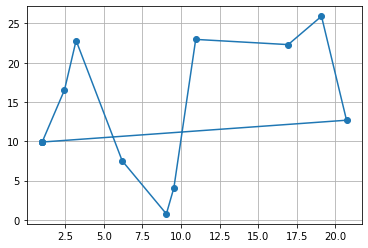

In [249]:
plotPolygon(vertices)